# Bayesian sampling of the posterior distribution

Part 2a: realistic case (RNA oligomers) -- limited number of observables (just 2 $^3J$ couplings)

In [1]:
import os, sys  # , pandas
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
import MDRefine
from MDRefine import load_data, minimizer, unwrap_2dict, loss_function, local_density, run_Metropolis

print('MDRefine version: ', MDRefine.__file__)

MDRefine version:  /home/ivang/Documenti/MDRefine/MDRefine/__init__.py


In [3]:
dir_name = 'Manuscript_images'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [4]:
alpha = 10  # 0.5

### 1. Load data

In [5]:
path_directory = '../../MDRefine/Examples/DATA/'

if not os.path.isdir(path_directory):
    print('directory does not exist')
    !echo "download DATA from Zenodo"
    !curl -O https://zenodo.org/records/14956459/files/DATA.zip

    !unzip DATA.zip
    !rm -r DATA.zip

    path_directory = 'DATA'

In [6]:
infos = {'global': {
    'path_directory': path_directory,
    'system_names': ['AAAA'],
    'g_exp': ['backbone1_gamma_3J'],  # , 'backbone2_beta_epsilon_3J', 'sugar_3J'],
    'forward_qs': ['backbone1_gamma'],  # , 'backbone2_beta_epsilon', 'sugar'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

In [7]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        s + '_3J' : fm_coeffs[0]*forward_qs_cos[s]**2 + fm_coeffs[1]*forward_qs_cos[s] + fm_coeffs[2] for s in forward_qs_cos.keys()}
    
    return forward_qs_out

In [8]:
infos['global']['forward_model'] = forward_model_fun

In [9]:
infos['global']['names_ff_pars'] = ['sin alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

# or:
# infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']
# def ff_correction(pars, f):
#     out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
#     return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction

In [10]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA


done


#### try with just 2 observables to make a 2d plot

In [11]:
assert list(data.mol.keys()) == ['AAAA'], 'ensure you have loaded just AAAA molecule'

name_mol = 'AAAA'

s = 'backbone1_gamma_3J'
my_mol = data.mol['AAAA']
# to avoid repeating `data.mol['AAAA']` you can act on `my_mol`, with the same results on `data.mol['AAAA']`
# because this does not create a copy, just a reference to the original object!

assert s in list(my_mol.g.keys()), 'ensure you have loaded just one kind of observables'

my_mol.gexp = {s: my_mol.gexp[s]}
my_mol.g = {s: my_mol.g[s]}
my_mol.names = {s: my_mol.names[s]}
my_mol.ref = {s: my_mol.ref[s]}
my_mol.forward_qs = {s[:-3]: my_mol.forward_qs[s[:-3]]}
my_mol.n_experiments = {s: my_mol.n_experiments[s]}

In [12]:
my_mol.gexp[s] = my_mol.gexp[s][:2, :]
my_mol.g[s] = my_mol.g[s][:, :2]
my_mol.names[s] = my_mol.names[s][:2]
my_mol.n_experiments[s] = 2

In [13]:
out = minimizer(data, alpha=alpha)

vars(out)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

{'loss': Array(0.40047414, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': Array([-0.05371164,  0.00235473], dtype=float64)}},
 'minis': {'AAAA':   message: Optimization terminated successfully.
    success: True
     status: 0
        fun: -0.040047414079243754
          x: [-1.103e-01  5.438e-03]
        nit: 4
        jac: [ 6.652e-06  8.342e-07]
   hess_inv: [[ 1.509e-01  9.405e-03]
              [ 9.405e-03  1.932e-01]]
       nfev: 7
       njev: 7},
 'time': 1.0745842456817627,
 'D_KL_alpha': {'AAAA': Array(0.00752873, dtype=float64)},
 'abs_difference': {'AAAA': Array(4.23083235e-11, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([2.59147448, 2.05297947], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(0.65037367, dtype=float64)}},
 'logZ_new': {'AAAA': Array(0.1268294, dtype=float64)},
 'weights_new': {'AAAA': Array([1.05121794e-04, 9.35425683e-05, 1.04592934e-04, ...,
         9.24773971e-05, 9.35587112e-05, 1.06554242e-04], d

In [14]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

x_min = flat_lambda(out.min_lambdas)

print(x_min)

[-0.05371164  0.00235473]


In [15]:
n = 40
delta = 10

# x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
# y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)

# x = np.concatenate((np.linspace(-1, 1, n), np.linspace(1, 6, n)))
# y = np.concatenate((np.linspace(-1, 1, n), np.linspace(1, 20, n)))

grid = np.meshgrid(x, y)[0]

In [16]:
sh = grid.shape

grid_vals_noJ = np.zeros(sh)
grid_vals_J = np.zeros(sh)
grid_vals_Dir = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=alpha, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)

        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol], which_measure='dirichlet')
        grid_vals_Dir[i, j] = grid_vals_noJ[i, j] - np.log(measure)

# REMEMBER TO TRANSPOSE GRIDS, otherwise they are plotted wrong!

grid_vals_noJ = grid_vals_noJ.T
grid_vals_J = grid_vals_J.T
grid_vals_Dir = grid_vals_Dir.T

In [17]:
direc_x = np.arange(0, 6, 0.05)
direc_y = direc_x*np.tan(0.3*np.pi)

min:  -1.3534150537102332
0.4274426192517514 55.57530811934893


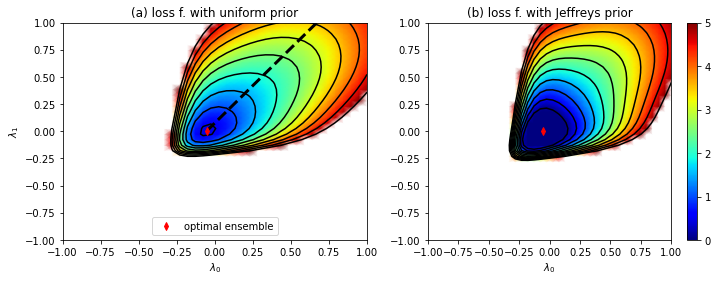

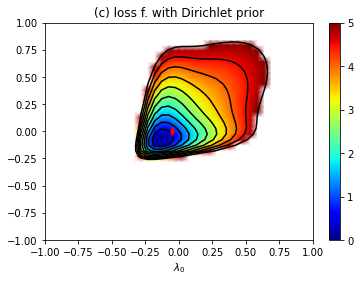

In [18]:
# matplotlib.rcParams['pcolor.shading']
# plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15
# plt.rcParams.update({'figure.autolayout': True})

print('min: ', np.min(grid_vals_J))

vmin = 0.
vmax = 5.
levels = np.linspace(vmin, vmax, 11)

cmap = plt.get_cmap('jet').copy()
cmap.set_over('white')
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].pcolormesh(x, y, grid_vals_noJ, cmap=cmap, norm=norm, shading='gouraud')
axs[0].set_xlabel('$\lambda_0$')
axs[0].set_ylabel('$\lambda_1$')
axs[0].set_title('(a) loss f. with uniform prior')

axs[0].contour(x, y, grid_vals_noJ, colors='k', levels=levels, linewidths=1.5)
axs[0].plot(x_min[0] + direc_x, x_min[1] + direc_y, 'k--')
axs[0].plot(x_min[0], x_min[1], 'dr', label='optimal ensemble', markersize=5)
axs[0].legend(loc='lower center')
axs[0].set_xlim([np.min(x), np.max(x)])
axs[0].set_ylim([np.min(y), np.max(y)])

##################################################################################################

im = axs[1].pcolormesh(x, y, grid_vals_J, cmap=cmap, norm=norm, shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].contour(x, y, grid_vals_J, colors='k', levels=levels, linewidths=1.5)
axs[1].plot(x_min[0], x_min[1], 'dr', label='optimal ensemble', markersize=5)
axs[1].set_xlabel('$\lambda_0$')
# plt.ylabel('$\lambda_1$')
axs[1].set_title('(b) loss f. with Jeffreys prior')

# plt.savefig('Manuscript_images/2_non-norm_stride%i_alpha%i_contour_line.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')

######################################################################################################
grid_vals_Dir -= np.min(grid_vals_Dir)

vmin = 0
vmax = 5
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
levels = np.linspace(vmin, vmax, 11)

plt.figure(figsize=(6, 4))
plt.pcolormesh(x, y, grid_vals_Dir, cmap=cmap, norm=norm, shading='gouraud')


plt.colorbar()
plt.contour(x, y, grid_vals_Dir, colors='k', levels=levels, linewidths=1.5)
plt.plot(x_min[0], x_min[1], 'dr', label='optimal ensemble', markersize=5)
plt.xlabel('$\lambda_0$')
# plt.ylabel('$\lambda_1$')
plt.title('(c) loss f. with Dirichlet prior')

# plt.savefig('Manuscript_images/2_Dirichlet_loss_contour_stide%i_non-norm_b_alpha%i.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')


print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

In [19]:
from Functions.basic_functions_gaussian import numerical_props

In [20]:
n_frames = len(data.mol['AAAA'].weights)
g = data.mol['AAAA'].g['backbone1_gamma_3J']
g_sigma_exp = data.mol['AAAA'].gexp['backbone1_gamma_3J']

num_props = numerical_props(n_frames, g, g_sigma_exp[:, 0], g_sigma_exp[:, 1], alpha)

num_props

           dV: 77.77814917867079
            g: Array([[3.60984924, 1.49698144, 3.52674602, ..., 1.3522938 , 1.56607649,
                       3.89858429],
                      [0.10827896, 1.47464387, 0.35459858, ..., 3.0378555 , 2.97742876,
                       0.94654087]], dtype=float64)
     lim_chi2: Array(2.11213606, dtype=float64)
      lim_dkl: Array(7.71225553, dtype=float64)
        lim_g: Array([ 3.05150348, -0.08313783], dtype=float64)
 lim_loss_num: 78.17862331949777
        lim_p: Array([6.41917256e-044, 0.00000000e+000, 3.16185537e-097, ...,
                      0.00000000e+000, 0.00000000e+000, 1.42489463e-226], dtype=float64)
      min_avg: array([2.59147707, 2.05297924])
   min_lambda: array([-0.05371213,  0.00235463])
     min_loss: 0.4004741408269884
         mini:   message: Optimization terminated successfully.
                 success: True
                  status: 0
                     fun: 0.4004741408269884
                       x: [-5.371e-02  2.355e

In [21]:
np.min(num_props.perim_loss)

78.17862331949777

In [22]:
print(num_props.dV)

77.77814917867079


##### angle of the lowest asymptotic value and loss along the perimeter

position of min. value along the perimeter:  [  4.99679292 500.00235463]


{'loss': Array(-28138444.21316961, dtype=float64),
 'loss_explicit': Array(78.17862332, dtype=float64),
 'D_KL_alpha': {'AAAA': Array(7.71225553, dtype=float64)},
 'abs_difference': {'AAAA': Array(28138522.39179293, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([ 3.15727199, -0.08307629], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(2.11213606, dtype=float64)}},
 'logZ_new': {'AAAA': Array(18.04985142, dtype=float64)},
 'weights_new': {'AAAA': Array([6.41917256e-044, 0.00000000e+000, 3.16185537e-097, ...,
         0.00000000e+000, 0.00000000e+000, 1.42489463e-226], dtype=float64)}}

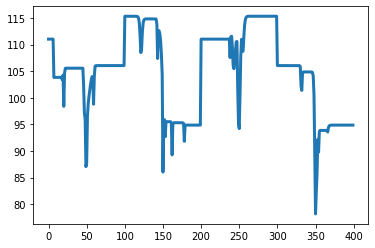

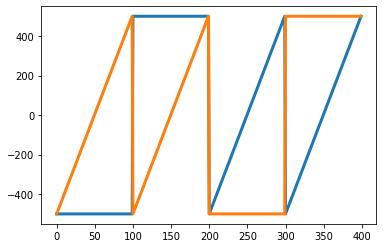

In [23]:
plt.plot(num_props.perim_loss)

plt.figure()
plt.plot(num_props.perimeter[0])
plt.plot(num_props.perimeter[1])

p = num_props.perimeter[:, np.argmin(num_props.perim_loss)]

print('position of min. value along the perimeter: ', p)

l = loss_function(np.zeros(2), data, regularization=None, alpha=alpha, fixed_lambdas=p, if_save=True)

vars(l)

In [24]:
def angles_from_sincos(sin, cos):

    angles = np.arcsin(sin)
    wh = np.argwhere(sin < 0)
    angles[wh] = np.pi - angles[wh]

    angles = np.mod(angles, 2*np.pi)

    wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
    angles[wh] = angles[wh] - 2*np.pi

    return angles

radius = np.linalg.norm(num_props.perimeter, axis=0)

sin = num_props.perimeter[1]/radius
cos = num_props.perimeter[0]/radius

angle = angles_from_sincos(sin, cos)

angle = np.arctan(num_props.perimeter[1]/num_props.perimeter[0])

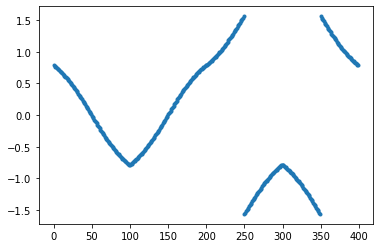

In [25]:
plt.plot(angle, '.')

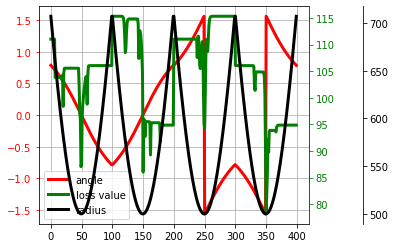

In [26]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.2))

host.grid()

p1, = host.plot(angle, 'r-', label="angle")
p2, = par1.plot(num_props.perim_loss, 'g-', label="loss value")
p3, = par2.plot(radius, 'k-', label='radius')

lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines], loc='lower left')

for ax in [par1, par2]:
    ax.set_frame_on(True)
    ax.patch.set_visible(False)

    plt.setp(ax.spines.values(), visible=False)
    ax.spines["right"].set_visible(True)

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

par1.spines["right"].set_edgecolor(p2.get_color())
par2.spines["right"].set_edgecolor(p3.get_color())

host.tick_params(axis='y', colors=p1.get_color())
par1.tick_params(axis='y', colors=p2.get_color())
par2.tick_params(axis='y', colors=p3.get_color())


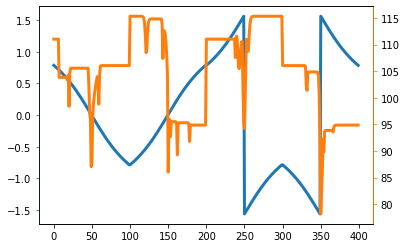

In [27]:
fig, ax1 = plt.subplots()


ax1.plot(angle)
ax1.tick_params(axis='y', color='tab:blue')
ax1.spines['left'].set_color('tab:blue')

ax2 = ax1.twinx()
ax2.plot(num_props.perim_loss, c='tab:orange')
ax2.tick_params(axis='y', color='tab:orange')
ax2.yaxis.label.set_color('tab:orange')
ax2.spines['right'].set_color('tab:orange')

$\Delta V = 3.85$ for `alpha = 0.5` and `stride = 100`

In [28]:
num_props.keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'perimeter', 'perim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'lim_p', 'lim_g', 'dV'])

In [29]:

num_props.perimeter

array([[-500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371213, -500.05371213,
        -500.05371213, -500.05371213, -500.05371

### 2. sampling

- start sampling from the point of minimum

In [30]:
optimal_solution = minimizer(data, alpha=alpha)

vars(optimal_solution)

References for MDRefine package:
I. Gilardoni, V. Piomponi, T. Fröhlking, and G. Bussi, “MDRefine: a Python package for refining Molecular Dynamics trajectories with experimental data”, arxiv (2024)

References for Ensemble Refinement:
J. W. Pitera and J. D. Chodera, “On the use of experimental observations to bias simulated ensembles”, J. Chem. Theory Comp. 8, 3445–3451 (2012).

G. Hummer and J. Köfinger, “Bayesian ensemble refinement by replica simulations and reweighting”, J. Chem. Phys. 143, 243150 (2015).

A. Cesari, A. Gil-Ley, and G. Bussi, “Combining simulations and solution experiments as a paradigm for RNA force field refinement”, J. Chem. Theory Comp. 12, 6192–6200 (2016).

A. Cesari, S. Reißer, and G. Bussi, “Using the maximum entropy principle to combine simulations and solution experiments”, Computation 6, 15 (2018).

J. Köfinger, L. S. Stelzl, K. Reuter, C. Allande, K. Reichel, and G. Hummer, “Efficient ensemble refinement by reweighting”, J. Chem. Theory Comput. 15, 339

{'loss': Array(0.40047414, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': Array([-0.05371164,  0.00235473], dtype=float64)}},
 'minis': {'AAAA':   message: Optimization terminated successfully.
    success: True
     status: 0
        fun: -0.040047414079243754
          x: [-1.103e-01  5.438e-03]
        nit: 4
        jac: [ 6.652e-06  8.342e-07]
   hess_inv: [[ 1.509e-01  9.405e-03]
              [ 9.405e-03  1.932e-01]]
       nfev: 7
       njev: 7},
 'time': 0.034377098083496094,
 'D_KL_alpha': {'AAAA': Array(0.00752873, dtype=float64)},
 'abs_difference': {'AAAA': Array(4.23083235e-11, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([2.59147448, 2.05297947], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(0.65037367, dtype=float64)}},
 'logZ_new': {'AAAA': Array(0.1268294, dtype=float64)},
 'weights_new': {'AAAA': Array([1.05121794e-04, 9.35425683e-05, 1.04592934e-04, ...,
         9.24773971e-05, 9.35587112e-05, 1.06554242e-04],

In [31]:
optimal_solution.av_g

{'AAAA': {'backbone1_gamma_3J': Array([2.59147448, 2.05297947], dtype=float64)}}

In [32]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

x_min = flat_lambda(optimal_solution.min_lambdas)

print(x_min)

[-0.05371164  0.00235473]


In [33]:
my_vals = loss_function(np.zeros(2), data, regularization=None, alpha=alpha, fixed_lambdas=[1, 1], if_save=True)

vars(my_vals)

{'loss': Array(-247.35036581, dtype=float64),
 'loss_explicit': Array(4.37578497, dtype=float64),
 'D_KL_alpha': {'AAAA': Array(0.33540278, dtype=float64)},
 'abs_difference': {'AAAA': Array(251.72615078, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': Array([1.71031531, 1.51924533], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': Array(2.04351429, dtype=float64)}},
 'logZ_new': {'AAAA': Array(-3.56496342, dtype=float64)},
 'weights_new': {'AAAA': Array([8.43646336e-05, 1.77976439e-04, 7.16599410e-05, ...,
         4.30829440e-05, 3.69575973e-05, 2.73345461e-05], dtype=float64)}}

In [34]:
# I can do this but it introduces a random number (I prefer to control the seed on MDRefine)
# def proposal(x0, dx=0.01):
#     x_new = x0 + dx*np.random.normal(size=len(x0))
#     return x_new

# proposal_move = lambda x : proposal(x, 0.2)

proposal_move = 0.2

# or:
# proposal_move = 'one-by-one'

In [35]:
def energy_fun(lambdas, which_measure='uniform'):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=alpha, fixed_lambdas=lambdas, if_save=True)
    
    """ vars(out).keys() = ['loss', 'loss_explicit', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2',
            'logZ_new', 'weights_new'] """
    
    energy = out.loss_explicit

    av_g = unwrap_2dict(out.av_g)[0]

    if which_measure != 'uniform':
        name_mol = list(out.weights_new.keys())[0]
        measure = local_density(data.mol[name_mol].g, out.weights_new[name_mol], which_measure)[0]
        energy -= np.log(measure)
    
    return energy, av_g

In [36]:
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def my_energy_fun(x0, which_measure):
    with suppress_stdout():
        return energy_fun(x0, which_measure)

In [37]:
x0 = x_min
energy_function = lambda x0 : my_energy_fun(x0, 'uniform')  # uniform in the lambda space
sampling_noJ = run_Metropolis(x0, proposal_move, energy_function, n_steps=int(2e4), seed=1)  # n_steps=int(2e4)

100%|██████████| 20000/20000 [02:41<00:00, 123.71it/s]


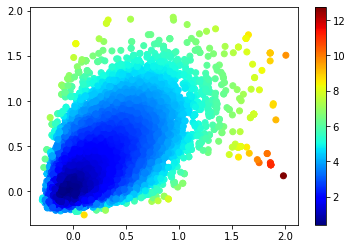

In [38]:
plt.scatter(sampling_noJ.traj[:, 0], sampling_noJ.traj[:, 1], c=sampling_noJ.ene, cmap='jet')
plt.colorbar()

about 70 iterations per sec. (for `stride = 10` and 2 observables)

In [39]:
energy_function = lambda x : my_energy_fun(x, 'jeffreys')
sampling_J = run_Metropolis(x0, proposal_move, energy_function, n_steps=int(2e4), seed=1)  # n_steps=int(2e4)


100%|██████████| 20000/20000 [02:54<00:00, 114.77it/s]


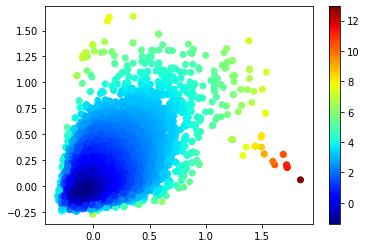

In [40]:
plt.scatter(sampling_J.traj[:, 0], sampling_J.traj[:, 1], c=sampling_J.ene, cmap='jet')
plt.colorbar()

#### 2b. analysis of sampling

Text(0.5, 1.0, '(f) sampled av. observables - Jeffreys')

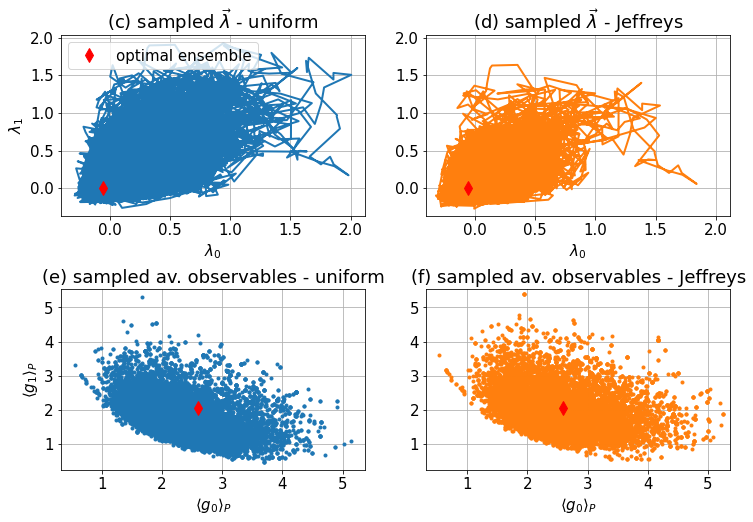

In [41]:
# plt.rcParams['lines.markeredgewidth'] = 0.5
# plt.rcParams['lines.linewidth'] = 1
plt.rcParamsDefault
plt.rcParams['font.size'] = 15

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

axs[0, 0].plot(sampling_noJ.traj[:, 0], sampling_noJ.traj[:, 1], c='tab:blue', linewidth=2)  # , label='uniform sampling')
axs[0, 1].plot(sampling_J.traj[:, 0], sampling_J.traj[:, 1], c='tab:orange', linewidth=2)  # label='Jeffreys prior')

x_min = flat_lambda(optimal_solution.min_lambdas)
axs[0, 0].plot(x_min[0], x_min[1], 'dr', markersize=10, label='optimal ensemble')
axs[0, 1].plot(x_min[0], x_min[1], 'dr', markersize=10)  # label='optimal ensemble')

axs[0, 1].set_xlim(axs[0, 0].get_xlim())
axs[0, 1].set_ylim(axs[0, 0].get_ylim())

axs[0, 0].set_xlabel('$\lambda_0$')
axs[0, 0].set_ylabel('$\lambda_1$')
axs[0, 1].set_xlabel('$\lambda_0$')

axs[0, 0].legend()
axs[0, 0].grid()
# axs[0, 1].legend()
axs[0, 1].grid()

axs[0, 0].set_title(r'(c) sampled $\vec\lambda$ - uniform')  #  sampling')
axs[0, 1].set_title(r'(d) sampled $\vec\lambda$ - Jeffreys')  #  prior')
# plt.savefig('Manuscript_images/ex2_sampling_lambdas_stride%i.pdf' % stride, format='pdf', bbox_inches='tight')

#########################################################################################################

plot_stride = 1

axs[1, 0].plot(sampling_noJ.quantities[::plot_stride, 0], sampling_noJ.quantities[::plot_stride, 1], '.', c='tab:blue')  # label='uniform sampling', zorder=1, markersize=4, alpha=1)
axs[1, 1].plot(sampling_J.quantities[::plot_stride, 0], sampling_J.quantities[::plot_stride, 1], '.', c='tab:orange')  # label='Jeffreys prior', zorder=0, markersize=4, alpha=1)

av_g = flat_lambda(optimal_solution.av_g)
axs[1, 0].plot(av_g[0], av_g[1], 'dr', markersize=10)  # label='optimal ensemble')
axs[1, 1].plot(av_g[0], av_g[1], 'dr', markersize=10)  # label='optimal ensemble')

# axs[1, 0].set_xlabel('observable n. 0')
# axs[1, 1].set_xlabel('observable n. 0')
# axs[1, 0].set_ylabel('observable n. 1')

axs[1, 0].set_xlabel(r'$\langle g_0 \rangle_P$')
axs[1, 1].set_xlabel(r'$\langle g_0 \rangle_P$')
axs[1, 0].set_ylabel(r'$\langle g_1 \rangle_P$')

# axs[1, 0].legend()
axs[1, 1].set_xlim(axs[1, 0].get_xlim())
axs[1, 1].set_ylim(axs[1, 0].get_ylim())

axs[1, 0].grid()
axs[1, 1].grid()
axs[1, 0].set_title('(e) sampled av. observables - uniform')
axs[1, 1].set_title('(f) sampled av. observables - Jeffreys')

# plt.savefig('Manuscript_images/ex2_sampling_obs_stride%i.pdf' % stride, format='pdf', bbox_inches='tight')
# plt.savefig('Manuscript_images/fig4_realistic_sampling_2obs_stride%s_non-norm_alpha%i.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')
# plt.savefig('Manuscript_images/2_non-norm_stride%i_alpha%i_sampling.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')


(0.0, 1610.7)

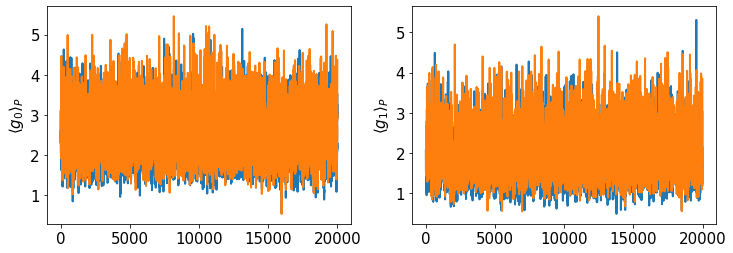

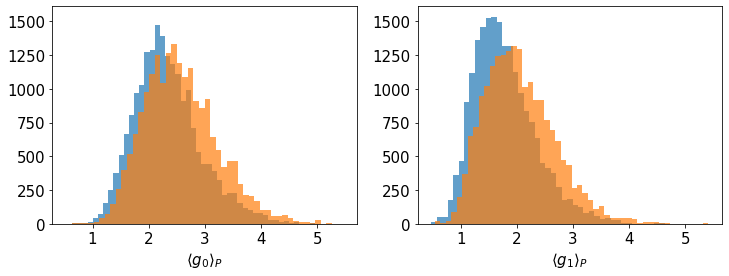

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# fig.subplots_adjust(hspace=0.3)

axs[0].plot(sampling_noJ.quantities[:, 0], c='tab:blue', linewidth=2)  # , label='uniform sampling')
axs[0].plot(sampling_J.quantities[:, 0], c='tab:orange', linewidth=2)  # label='Jeffreys prior')
axs[0].set_ylabel(r'$\langle g_0 \rangle_P$')

axs[1].plot(sampling_noJ.quantities[:, 1], c='tab:blue', linewidth=2)
axs[1].plot(sampling_J.quantities[:, 1], c='tab:orange', linewidth=2)  # label='optimal ensemble')
axs[1].set_ylabel(r'$\langle g_1 \rangle_P$')

# plt.savefig('Manuscript_images/2_non-norm_stride%i_alpha%i_observables_timeseries.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')


# axs[1].set_xlim(axs[0].get_xlim())
# axs[1].set_ylim(axs[0].get_ylim())

# axs[0].set_xlabel('$\lambda_0$')
# axs[0].set_ylabel('$\lambda_1$')
# axs[1].set_xlabel('$\lambda_0$')

# axs[0].legend()
# axs[0].grid()
# # axs[1].legend()
# axs[1].grid()

# axs[0].set_title(r'(c) sampled $\vec\lambda$ - uniform sampling')
# axs[1].set_title(r'(d) sampled $\vec\lambda$ - Jeffreys prior')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

n_bins = 50

axs[0].hist(sampling_noJ.quantities[:, 0], bins=n_bins, alpha=0.7)#, c='tab:blue')#, linewidth=2)  # , label='uniform sampling')
axs[0].hist(sampling_J.quantities[:, 0], bins=n_bins, alpha=0.7)#, c='tab:orange')#, linewidth=2)  # label='Jeffreys prior')
axs[0].set_xlabel(r'$\langle g_0 \rangle_P$')
x_lim = axs[0]

axs[1].hist(sampling_noJ.quantities[:, 1], bins=n_bins, alpha=0.7)#, c='tab:blue')#, linewidth=2)
axs[1].hist(sampling_J.quantities[:, 1], bins=n_bins, alpha=0.7)#, c='tab:orange')#, linewidth=2)  # label='optimal ensemble')
axs[1].set_xlabel(r'$\langle g_1 \rangle_P$')

ylims = axs[1].get_ylim()
axs[0].set_ylim(ylims)

# plt.savefig('Manuscript_images/2_non-norm_stride%i_alpha%i_observables_hist.pdf' % (stride, alpha), format='pdf', bbox_inches='tight')


In [43]:
print('acceptance: ', sampling_noJ.av_acceptance, sampling_J.av_acceptance)

acceptance:  0.5646 0.42145


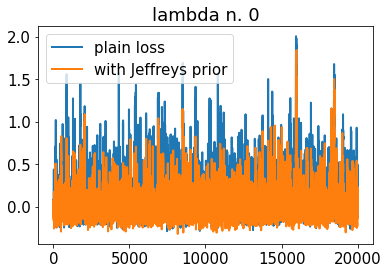

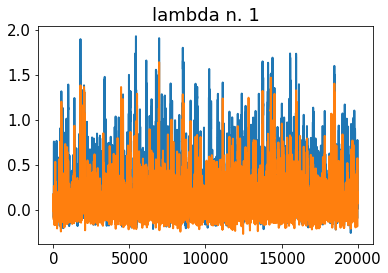

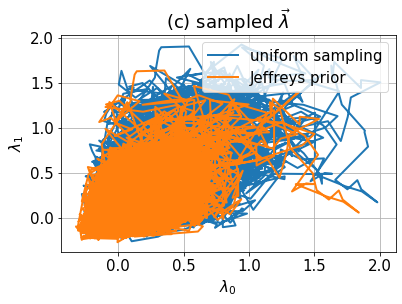

In [44]:
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams.update({'figure.autolayout': True})

n_obs = sampling_noJ.traj.shape[1]

for i in range(n_obs):
    plt.figure()
    plt.title('lambda n. %i' % i)
    plt.plot(sampling_noJ.traj[:, i], label='plain loss')
    plt.plot(sampling_J.traj[:, i], label='with Jeffreys prior')
    if i == 0 : plt.legend()

if (n_obs == 2):
    plt.figure(figsize=(6, 4))
    plt.plot(sampling_noJ.traj[:, 0], sampling_noJ.traj[:, 1], label='uniform sampling')
    plt.plot(sampling_J.traj[:, 0], sampling_J.traj[:, 1], label='Jeffreys prior')
    plt.xlabel('$\lambda_0$')
    plt.ylabel('$\lambda_1$')
    plt.legend()
    plt.grid()
    plt.title(r'(c) sampled $\vec\lambda$')
    # plt.savefig('Manuscript_images/ex2_sampling_lambdas_b.pdf', format='pdf', bbox_inches='tight')

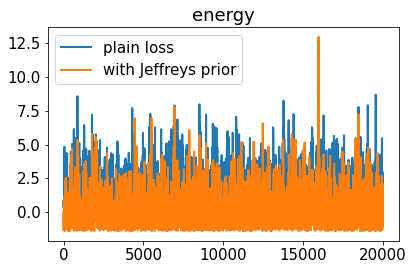

In [45]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'figure.autolayout': True})


plt.figure()
plt.title('energy')
plt.plot(sampling_noJ.ene, label='plain loss')
plt.plot(sampling_J.ene, label='with Jeffreys prior')
plt.legend()


Text(0.5, 1.0, '(d) sampled observables')

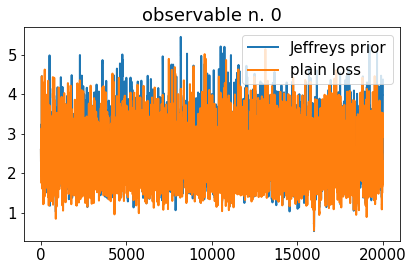

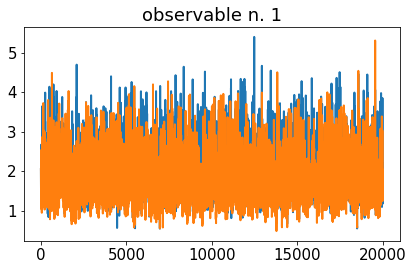

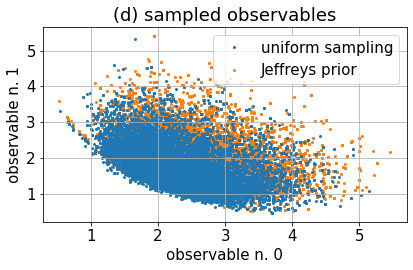

In [46]:
for i in range(2):
    plt.figure()
    plt.title('observable n. %i' % i)
    plt.plot(sampling_J.quantities[:, i], label='Jeffreys prior')
    plt.plot(sampling_noJ.quantities[:, i], label='plain loss')
    if i == 0 : plt.legend()

# plt.rcParams.update({'figure.autolayout': True})
plt.figure(figsize=(6, 4))
# plt.rcParams['lines.markeredgewidth'] = 0.5

plot_stride = 1
plt.plot(sampling_noJ.quantities[::plot_stride, 0], sampling_noJ.quantities[::plot_stride, 1], '.', label='uniform sampling', zorder=1, markersize=4, alpha=1)
plt.plot(sampling_J.quantities[::plot_stride, 0], sampling_J.quantities[::plot_stride, 1], '.', label='Jeffreys prior', zorder=0, markersize=4, alpha=1)

plt.xlabel('observable n. 0')
plt.ylabel('observable n. 1')
plt.legend()
plt.grid()
plt.title('(d) sampled observables')
# plt.savefig('Manuscript_images/ex2_sampling_obs_b.pdf', format='pdf', bbox_inches='tight')


In [47]:
av_lambdas_noJ = np.mean(sampling_noJ.traj, axis=0)
av_lambdas_J = np.mean(sampling_J.traj, axis=0)

av_obs_noJ = np.mean(sampling_noJ.quantities, axis=0)
av_obs_J = np.mean(sampling_J.quantities, axis=0)

std_obs_noJ = np.std(sampling_noJ.quantities, axis=0)
std_obs_J = np.std(sampling_J.quantities, axis=0)

print(av_obs_noJ, av_obs_J, av_g)
print(std_obs_noJ, std_obs_J)


[2.34040306 1.785053  ] [2.57335715 2.04981803] [2.59147448 2.05297947]
[0.59468446 0.55332477] [0.64889191 0.61510246]


### 3. repeat over different seeds

In [48]:
outs = {}

n_steps = int(2e4)
measures = ['uniform', 'jeffreys']  # , 'var', 'dirichlet']

for s in measures: outs[s] = []

seeds = np.arange(1, 6)  # the default seed (used for the images in the manuscript) is `seed = 2`

for seed in seeds:
    for measure in measures:
        energy_function = lambda x : my_energy_fun(x, measure)
        outs[measure].append(run_Metropolis(x0, proposal_move, energy_function, n_steps=n_steps, seed=seed))
        # outs[measure][-1].quantities[:, 0] = np.concatenate(outs[measure][-1].quantities[:, 0])


100%|██████████| 20000/20000 [02:35<00:00, 128.35it/s]


100%|██████████| 20000/20000 [03:18<00:00, 100.86it/s]


100%|██████████| 20000/20000 [03:22<00:00, 98.72it/s] 


100%|██████████| 20000/20000 [03:29<00:00, 95.52it/s] 


100%|██████████| 20000/20000 [02:53<00:00, 115.17it/s]


100%|██████████| 20000/20000 [03:30<00:00, 95.14it/s] 


100%|██████████| 20000/20000 [03:18<00:00, 100.96it/s]


100%|██████████| 20000/20000 [03:45<00:00, 88.81it/s]


100%|██████████| 20000/20000 [03:23<00:00, 98.45it/s] 


100%|██████████| 20000/20000 [03:43<00:00, 89.64it/s]


#### 3b. block analysis

In [49]:
from Functions.basic_functions_bayesian import block_analysis

In [57]:
bl_outs = {}

strides = [100, 50, 10, 5, 1]

for stride in strides:
    bl_outs[stride] = block_analysis(sampling_J.quantities[:, 1][::stride], None)

    print('stride: ', stride)
    print('average: ', bl_outs[stride].mean)
    print('std: ', bl_outs[stride].std)
    print('optimal epsilon: ', bl_outs[stride].opt_epsilon)

stride:  100
average:  2.139979601162976
std:  0.0431366565495806
optimal epsilon:  0.03208891139164717
stride:  50
average:  2.111049897083814
std:  0.030525382896211543
optimal epsilon:  0.029714353124868607
stride:  10
average:  2.063496060310035
std:  0.014002335505646155
optimal epsilon:  0.017159370096307015
stride:  5
average:  2.0513080505769175
std:  0.009749192226775122
optimal epsilon:  0.01590329350365944
stride:  1
average:  2.049818030624591
std:  0.004349322495379007
optimal epsilon:  0.014226230263968825


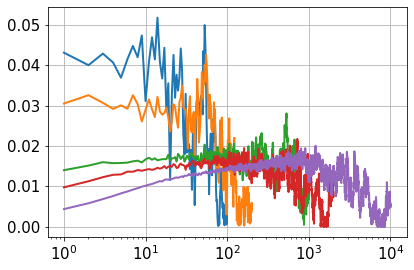

In [ ]:
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, stride in enumerate(strides):
    plt.plot(bl_outs[stride].size_blocks, bl_outs[stride].epsilons, c=default_colors[i])
    # plt.plot(bl_outs[stride].size_blocks, bl_outs[stride].epsilons_smooth, c=default_colors[i])
plt.xscale('log')
plt.grid()

In [60]:
bl_outs = {}

strides = [100, 50, 10, 5, 1]

for stride in strides:
    bl_outs[stride] = block_analysis(sampling_noJ.quantities[:, 1][::stride], None)

    print('stride: ', stride)
    print('average: ', bl_outs[stride].mean)
    print('std: ', bl_outs[stride].std)
    print('optimal epsilon: ', bl_outs[stride].opt_epsilon)

stride:  100
average:  1.785890669445475
std:  0.035382856367700714
optimal epsilon:  0.026908524293107104
stride:  50
average:  1.7697250646837417
std:  0.025876412141373296
optimal epsilon:  0.02422871315603791
stride:  10
average:  1.7753111958600576
std:  0.012050245908355626
optimal epsilon:  0.01696946375014915
stride:  5
average:  1.7793087945983972
std:  0.008615395034249882
optimal epsilon:  0.016468973382139686
stride:  1
average:  1.7850530003803973
std:  0.003912499125754791
optimal epsilon:  0.014998327597525571


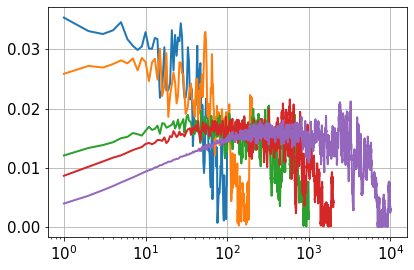

In [61]:
default_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i, stride in enumerate(strides):
    plt.plot(bl_outs[stride].size_blocks, bl_outs[stride].epsilons, c=default_colors[i])
    # plt.plot(bl_outs[stride].size_blocks, bl_outs[stride].epsilons_smooth, c=default_colors[i])
plt.xscale('log')
plt.grid()